# Citibike trip data analysis

Let's look at one of the datasets from [CitiBike trip data](https://s3.amazonaws.com/tripdata/index.html), that lists individual bike trips for a given month.

To follow along, download [the September 2016](https://s3.amazonaws.com/tripdata/201609-citibike-tripdata.zip) data, unzip it, and place it in the same directory as this notebook.

## Background

Citi Bike publishes two data sources: a live feed and a monthly trip report.

### Live Feed

The live feed is a list of bike stations, the # of bikes available and # of spots available. We poll it every five minutes.

### Monthly Report

A list of bike trips. Each trip has a start time, end time, start station, end station, and metadata about a user. This doc is about the monthly report.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
fname = '201609-citibike-tripdata.zip'

frame = pd.read_csv(fname)

frame[:3]

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender
0,975,9/1/2016 00:00:02,9/1/2016 00:16:18,312,Allen St & Stanton St,40.722055,-73.989111,313,Washington Ave & Park Ave,40.696102,-73.967510,22609,Subscriber,1985.0,1
1,1220,9/1/2016 00:00:04,9/1/2016 00:20:25,316,Fulton St & William St,40.709560,-74.006536,239,Willoughby St & Fleet St,40.691966,-73.981302,16966,Subscriber,1977.0,2
2,308,9/1/2016 00:00:19,9/1/2016 00:05:27,479,9 Ave & W 45 St,40.760193,-73.991255,448,W 37 St & 10 Ave,40.756604,-73.997901,25601,Subscriber,1983.0,1


In [8]:
station_names = frame.groupby('start station id').max()[
        ['start station name',
        'start station latitude',
        'start station longitude']]
station_names[:3]

,start station name,start station latitude,start station longitude
start station id,,,
72,W 52 St & 11 Ave,40.767272,-73.993929
79,Franklin St & W Broadway,40.719116,-74.006667
82,St James Pl & Pearl St,40.711174,-74.000165


## Single Station

Let's look at a single station and find out the departure and arrival times.

In [25]:
for name, group in frame[:10000].groupby('start station id'):
    if len(group) < 100:
        continue
    print (name)
    
# These are the busy stations.
print(station_names.loc[519]) # Grand Central
print(station_names.loc[3236]) # Times Square

519
3236
start station name         Pershing Square North
start station latitude                   40.7519
start station longitude                 -73.9777
Name: 519, dtype: object
start station name         W 42 St & Dyer Ave
start station latitude                 40.759
start station longitude              -73.9938
Name: 3236, dtype: object


In [63]:
def get_event_frame(station_id):
    _start = pd.DataFrame(frame[frame['start station id'] == station_id][['starttime']])
    _start.columns = ['time']
    _start['type'] = -1
    _end = pd.DataFrame(frame[frame['end station id'] == station_id]['stoptime'])
    _end.columns = ['time']
    _end['type'] = 1

    events = pd.concat([_start, _end])
    events['ts'] = pd.to_datetime(events['time'], infer_datetime_format=True)
    events = events.sort_values(by='ts')
    events['cumulative'] = events['type'].cumsum()
    events['date'] = events['time'].str[:len('1/1/1000')]
    events['tdiff'] = events['ts'].diff()
    events.drop('time', axis=1, inplace=True)

    return events

ps_north = get_event_frame(519)
print(len(ps_north))

ps_north[:10]

32771


,type,ts,cumulative,date,tdiff
7,-1,2016-09-01 00:00:48,-1,9/1/2016,NaT
14,-1,2016-09-01 00:00:59,-2,9/1/2016,00:00:11
26,1,2016-09-01 00:09:56,-1,9/1/2016,00:08:57
37,1,2016-09-01 00:13:47,0,9/1/2016,00:03:51
174,-1,2016-09-01 00:17:08,-1,9/1/2016,00:03:21
202,-1,2016-09-01 00:20:13,-2,9/1/2016,00:03:05
100,1,2016-09-01 00:20:55,-1,9/1/2016,00:00:42
216,-1,2016-09-01 00:21:19,-2,9/1/2016,00:00:24
613,-1,2016-09-01 02:00:27,-3,9/1/2016,01:39:08
776,-1,2016-09-01 04:02:13,-4,9/1/2016,02:01:46


Now we have a dataframe of bike arrivals and departures from the station "Pershing Square North" (outside Grand Central). Columns:
* `type`: 1 is an arrival (1 more bike in the station), and -1 is departure
* `ts`: Timestamp of event
* `cumulative`: Net station state after all rows so far (e.g. -4 = station has 4 fewer bikes than start of dataset)
* `date`: Date of event as a string
* `tdiff`: Time between this event and the previous one

Let's plot some charts:

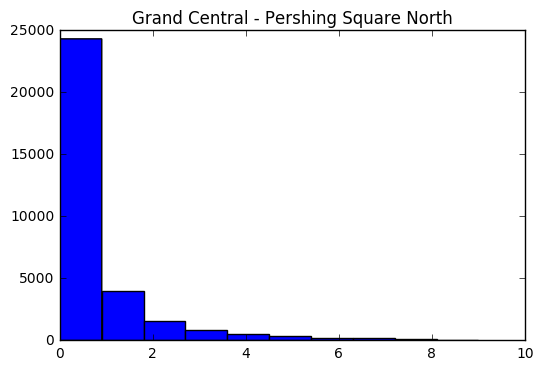

Proportion of <1m intervals: 0.7422337503814465


In [77]:
# time deltas rounded down to the nearest minute
import numpy as np
deltas = [td.total_seconds() // 60 for td in ps_north['tdiff'][1:]]
d10 = [td for td in deltas if td < 10]

plt.figure()
plt.title('Grand Central - Pershing Square North')
plt.hist(d10)
plt.show()

dzero = list(filter(lambda x: x == 0, deltas))

print('Proportion of <1m intervals:', len(dzero) / len(deltas))

So the Grand Central station is very busy, with three quarters of bike events happening within a minute of each other. That means our 5-minute polling interval doesn't have enough resolution for the busiest stations. On the other hand, polling every 10 seconds is also unrealistic.

Let's try other stations.

In [73]:
def get_10m_histogram(events, title):
    """Gets inter-arrival histogram values for 0 to 10 minutes."""
    in_minutes = [td.total_seconds() // 60 for td in events['tdiff'][1:]]
    d10 = [td for td in in_minutes if td < 10]

    plt.figure()
    plt.hist(d10)
    plt.title(title)
    plt.show()

    dzero = list(filter(lambda x: x == 0, in_minutes))
    dfive = list(filter(lambda x: x < 5, in_minutes))
    print('Proportion of <1m intervals:', len(dzero) / len(in_minutes))
    print('Proportion of <5m intervals:', len(dfive) / len(in_minutes))
    print('Proportion of <10m intervals:', len(d10) / len(in_minutes))

qp_north = get_event_frame(3129) # Queens Plaza North
high_line = get_event_frame(225) # W 14 St and High Line
nyu_bike = get_event_frame(335) # Washington Pl and Broadway

4568


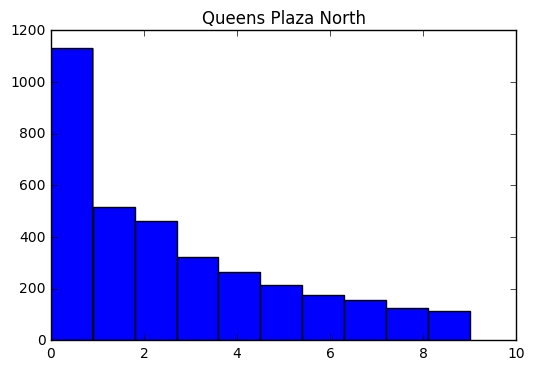

Proportion of <1m intervals: 0.24742719509524852
Proportion of <5m intervals: 0.5907597985548501
Proportion of <10m intervals: 0.7633019487628641


In [74]:
print(len(qp_north))
get_10m_histogram(qp_north, 'Queens Plaza North')

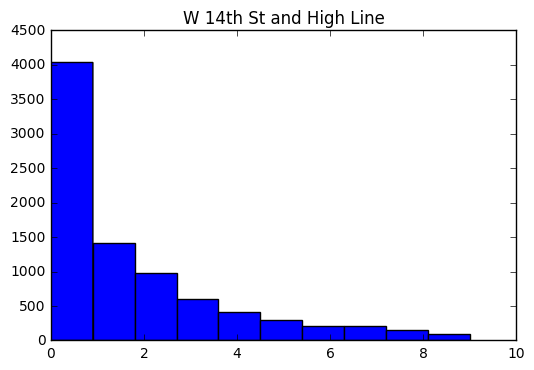

Proportion of <1m intervals: 0.4389686684073107
Proportion of <5m intervals: 0.8098346388163621
Proportion of <10m intervals: 0.9137293298520452


In [75]:
get_10m_histogram(high_line, 'W 14th St and High Line')

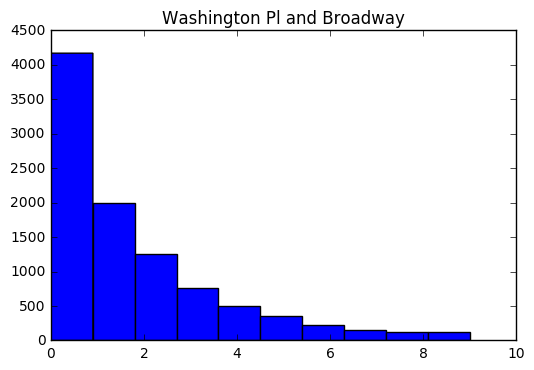

Proportion of <1m intervals: 0.40321021079094954
Proportion of <5m intervals: 0.8399729259330884
Proportion of <10m intervals: 0.9354090117965578


In [76]:
get_10m_histogram(nyu_bike, 'Washington Pl and Broadway')

## Conclusions

1. If we're just looking at station status (# bikes/spots available) every five minutes, the polling resolution is probably too low.
1. Increasing polling resolution isn't really practical
1. This dataset seems useful to get the level of activity of a station at a given time interval

-cipta